In [11]:
import os, sys
from pathlib import Path
import torch
import tifffile as tiff

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')

ncomps = 50
model_comps = 500
dr_method = 'PCA'

exp_name="far_bias"

test_path = train_path = macaw_path/exp_name/f'test_hc_data_PCA_{model_comps}.pkl'
model_base_path = macaw_path/'models'/exp_name/f'{dr_method}_{model_comps}'/f'{ncomps}'

In [12]:
import pickle

with open(train_path, 'rb') as f:
    train = pickle.load(f)
    
disease = train['disease']
bias = train['bias']
train_imgs = train['imgs']

encoded_data = train['encoded_data']
pca = train['pca']

img_names = train['img_names']

In [13]:
with open(model_base_path/'hyperparameters.pkl', 'rb') as f:
    hp = pickle.load(f)
    
ncomps= hp['ncomps']
nevecs= hp['nevecs']
nbasecomps= hp['nbasecomps']
ncauses= hp['ncauses']
crop_size= hp['crop_size']

In [14]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

def recons(age,bmi,latents, latent_offset=0):
    
    # bmi = scaler_b.inverse_transform(bmi)
    # print(age)
    latent_enc = np.zeros((latents.shape[0],ncomps))
    latent_enc[:,latent_offset:latent_offset+latents.shape[1]] = latents    
    # latent_enc = scaler_i.inverse_transform(latent_enc)
    imgs = pca.inverse_transform(latent_enc)
    return age,bmi,imgs

In [15]:
sample_imgs = train_imgs[:5,:]
t = pca.transform(sample_imgs)
X_recon = pca.inverse_transform(t)

In [16]:
def make_img(x):
    img = (255*x/np.max(x)).reshape(crop_size,crop_size)
    return np.clip(img,0, 255).astype('uint8')

In [17]:
import glob
from PIL import Image

def make_gif(frames, save_name):    
    frames = [Image.fromarray(f) for f in frames]
    frame_one = frames[0]
    return frame_one.save(save_name, format="GIF", append_images=frames, save_all=True, duration=100, loop=0)

In [18]:
from torchvision.transforms import CenterCrop
from utils.customTransforms import ToFloatUKBB
from monai.transforms import Compose, ToTensor
transforms = Compose([ToTensor(),CenterCrop(crop_size),ToFloatUKBB()])

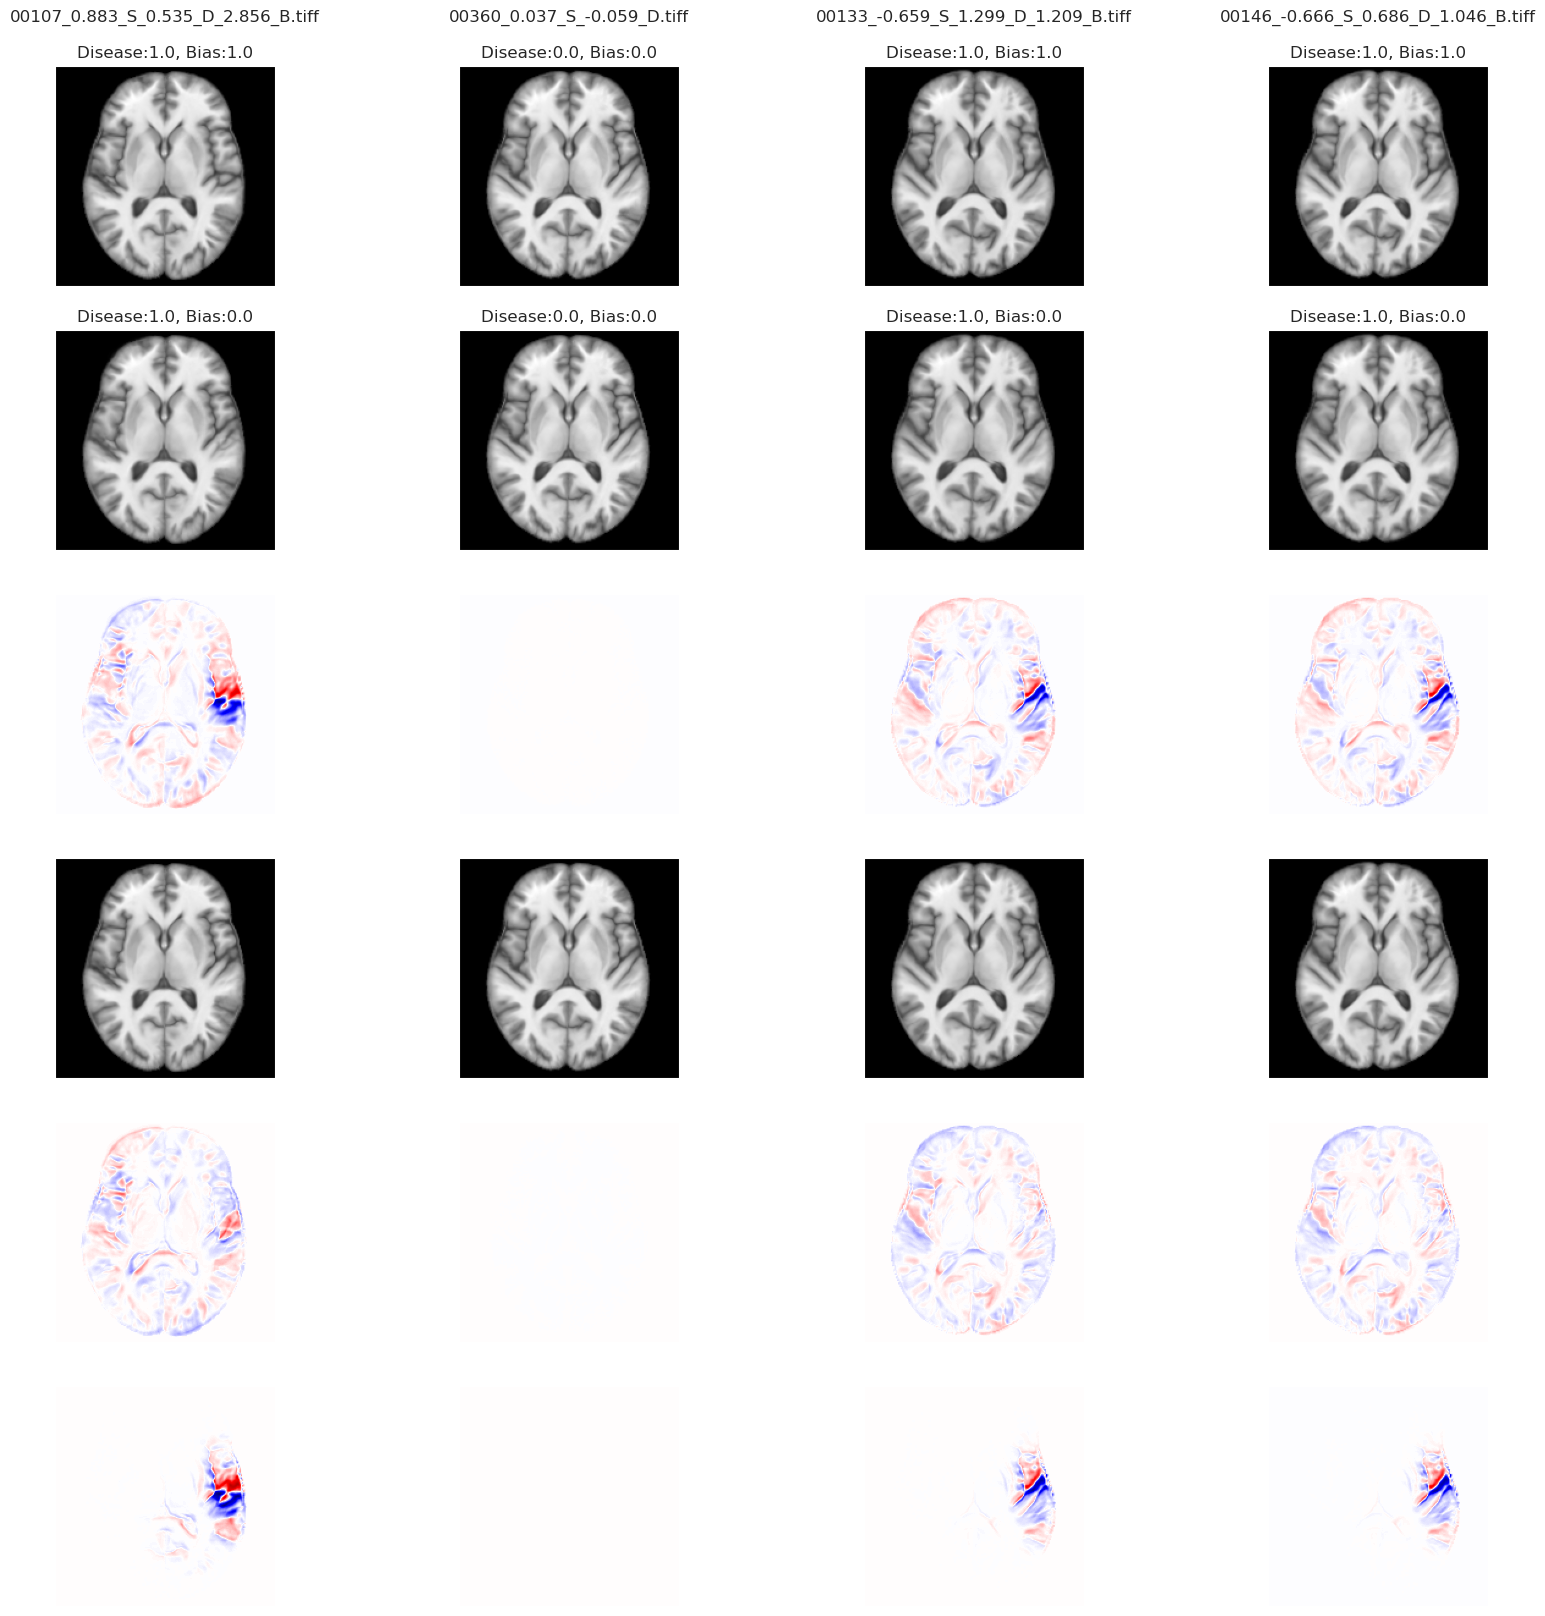

In [28]:
import SimpleITK as sitk
import numpy as np
import torch

save_name = f'data/{exp_name}/cntr/'
cf_vals = {1:0}
nsamples = 4
image_shape = (180, 180)  # Assuming each image is 180x180

rands = np.random.randint(0, encoded_data.shape[0], nsamples)
d_obs = train_imgs[rands, :]
encoded_obs = encoded_data[rands, :]

names = img_names[rands]
dis_obs = disease[rands]
bias_obs = bias[rands]
residuals = d_obs - pca.inverse_transform(encoded_obs)

cf = np.zeros((nsamples, ncomps))
for ev in range(0, ncomps - nbasecomps, nevecs - nbasecomps):
    ed = encoded_obs[:, ev:ev + nevecs]
    X_obs = np.hstack([dis_obs[:, np.newaxis], bias_obs[:, np.newaxis], ed])
    try:
        macaw = torch.load(model_base_path / f'{ev}.pt')
        cc = macaw.counterfactual(X_obs, cf_vals)
    except Exception as e:
        print(e, "Using original")
        cc[:, ncauses:] = X_obs[:, ncauses:].copy()

    cf[:, ev:ev + nevecs] = cc[:, ncauses:]

re_cf = recons(cc[:, 0], cc[:, 1], cf)
re_cf_resd = re_cf[2] + residuals

# Convert numpy arrays to SimpleITK images
def numpy_to_sitk(img):
    return sitk.GetImageFromArray(img.astype(np.float32))

def sitk_to_numpy(img):
    return sitk.GetArrayFromImage(img)

# Perform histogram matching
matched_images = []
for i in range(nsamples):
    # Reshape the arrays to 2D images
    source_img_2d = re_cf_resd[i].reshape(image_shape).astype(np.float32)
    reference_img_2d = d_obs[i].reshape(image_shape).astype(np.float32)
    
    source_img = numpy_to_sitk(source_img_2d)
    reference_img = numpy_to_sitk(reference_img_2d)
    
    matcher = sitk.HistogramMatchingImageFilter()
    matcher.SetNumberOfHistogramLevels(500)
    matcher.SetNumberOfMatchPoints(50)
    matcher.SetThresholdAtMeanIntensity(False)
    matched_img = matcher.Execute(source_img, reference_img)
    
    # Convert the matched image back to a numpy array and reshape to original shape
    matched_img_array = sitk_to_numpy(matched_img).reshape(-1)
    matched_images.append(matched_img_array)

# Convert the matched images back to a numpy array
re_cf_resd = np.array(matched_images)

# Ensuring values are still in the range [0, 1] after histogram matching
# re_cf_resd = np.clip(re_cf_resd, 0, 1)

# Continue with the rest of your code as needed



diff = d_obs - re_cf_resd

fig,axs = plt.subplots(6,nsamples, figsize=(20,20))

lim=0.5
lims=(-lim,lim)

for i in range(nsamples):
    axs[0,i].imshow(d_obs[i].reshape(crop_size,crop_size),cmap='gray')
    axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'{names[i]}\n\nDisease:{X_obs[i,0]}, Bias:{X_obs[i,1]}')

    axs[1,i].imshow(make_img(re_cf_resd[i]),cmap='gray')
    axs[1,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'Disease:{cc[i,0]}, Bias:{cc[i,1]}')

    axs[2,i].imshow(diff[i].reshape(crop_size,crop_size),cmap='seismic', clim=lims)
    axs[2,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    img = tiff.imread('no_bias/test/'+img_names[rands[i]])
    img = transforms(img).reshape(crop_size,crop_size)

    axs[3,i].imshow(img,cmap='gray')
    axs[3,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    # diff between cf no_bias and ground truth no_bias, ideally would have no difference
    axs[4,i].imshow((re_cf_resd[i].reshape(crop_size,crop_size)) - img,cmap='seismic', clim=lims)
    axs[4,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    # shows the bias Emma added
    axs[5,i].imshow(d_obs[i].reshape(crop_size,crop_size) - img,cmap='seismic', clim=lims)
    axs[5,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
if not os.path.exists(save_name):
    os.makedirs(save_name)

plt.savefig(save_name+f"cf1.pdf")
plt.show()

In [20]:
for i in range(nsamples):
    print(min(re_cf_resd[i]),max(re_cf_resd[i]))

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


In [21]:
i=0

(array([14075.,   156.,   111.,   120.,   179.,   266.,   417.,   643.,
          816.,  1021.,  1187.,  1396.,  1583.,  1598.,  1516.,  1584.,
         1755.,  2057.,  1792.,   128.]),
 array([0.        , 0.05      , 0.1       , 0.15000001, 0.2       ,
        0.25      , 0.30000001, 0.34999999, 0.40000001, 0.44999999,
        0.5       , 0.55000001, 0.60000002, 0.64999998, 0.69999999,
        0.75      , 0.80000001, 0.85000002, 0.89999998, 0.94999999,
        1.        ]),
 <BarContainer object of 20 artists>)

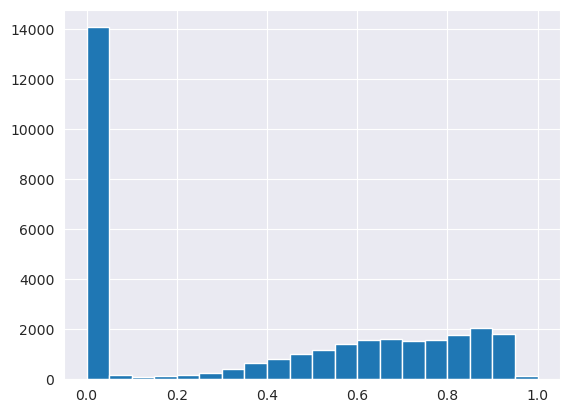

In [22]:
plt.hist(re_cf_resd[i], bins=20)
# plt.yscale("log")

(array([14065.,   148.,   137.,   123.,   156.,   241.,   449.,   638.,
          849.,  1002.,  1167.,  1381.,  1630.,  1593.,  1509.,  1563.,
         1737.,  2090.,  1796.,   126.]),
 array([0.        , 0.05      , 0.1       , 0.15000001, 0.2       ,
        0.25      , 0.30000001, 0.34999999, 0.40000001, 0.44999999,
        0.5       , 0.55000001, 0.60000002, 0.64999998, 0.69999999,
        0.75      , 0.80000001, 0.85000002, 0.89999998, 0.94999999,
        1.        ]),
 <BarContainer object of 20 artists>)

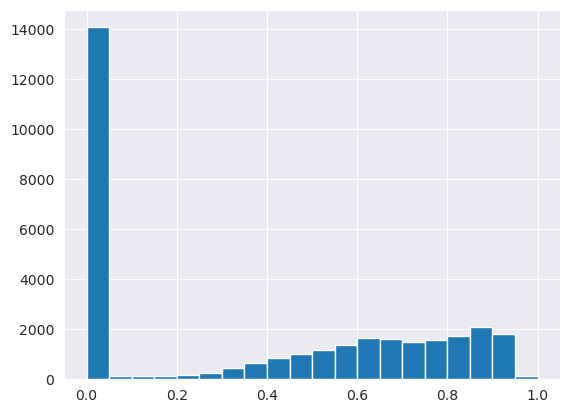

In [23]:
plt.hist(d_obs[i], bins=20)
# plt.yscale("log")

In [24]:
n = rands[2]

In [25]:
fb_img = tiff.imread('far_bias/train/'+ img_names[n])
fb_img = transforms(fb_img).reshape(crop_size,crop_size)

nb_img = tiff.imread('no_bias/train/'+ img_names[n])
nb_img = transforms(nb_img).reshape(crop_size,crop_size)

FileNotFoundError: [Errno 2] No such file or directory: '/home/volatope/PycharmProjects/CounterBias/far_bias/train/00152_0.712_S_0.63_D_2.035_B.tiff'

In [ ]:
img_names[n]

In [ ]:
print(disease[n], bias[n])

In [ ]:
plt.imshow(fb_img-nb_img,cmap='seismic')

In [ ]:
re_cf_resd[2]